# Kolmogorov-Arnold Networks for Regression

**Since my laptop's resources were insufficient, Colab Pro with an A100 GPU hardware accelerator was used to train this model.**

- This notebook demonstrates the implementation of Kolmogorov-Arnold Networks (KAN) for the regression task of predicting exchange bias shift
- The data has been thoroughly prepared, and key hyperparameters (k, grid, width, learning rate) have been optimized using Optuna
- The purpose of this notebook is to showcase how KAN handles the regression task and interprets feature importance using SHAP analysis

In [ ]:
!pip install git+https://github.com/KindXiaoming/pykan.git > None

  Running command git clone --filter=blob:none --quiet https://github.com/KindXiaoming/pykan.git /tmp/pip-req-build-tpo253xj


In [ ]:
import torch
from kan import KAN
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from scipy.ndimage import gaussian_filter1d

In [ ]:
# Fixing random seed for reproducibility
def seed_everything(seed=1984):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)

seed_everything(1984)

In [ ]:
# Loading data
df = pd.read_csv("Data/final_data_exchange_bias.csv")

# Dropping unnecessary columns
df = df.drop(columns=['core', 'shell', 'formula'])

In [ ]:
# Renaming columns
rename_dict = {
    'area/volume': 'Area to volume ratio',
    'h_range_max_koe': 'Maximum field range',
    'Tc': 'Curie temperature',
    'temperature_k': 'Experimental temperature',
    'sat_em_g': 'Saturation magnetization',
    'coer_oe': 'Coercivity',
    'mr (emu/g)': 'Remanent magnetization',
    'exc_bias_oe': 'Exchange bias shift',
    'exc_dir': 'Exchange shift direction',
    'ver_shift_emu_g': 'Vertical shift',
    'ver_s_dir': 'Vertical shift direction',
    'fc_field_t': 'Magnetic field strength',
    'sphericity': 'Sphericity',
    'max/min': 'Geometric anisotropy',
    'core_b': 'Core b lattice parameter',
    'core_alpha': 'Core alpha angle',
    'core_beta': 'Core beta angle',
    'core_gamma': 'Core gamma angle',
    'shell_b': 'Shell b lattice parameter',
    'shell_alpha': 'Shell alpha angle',
    'shell_beta': 'Shell beta angle',
    'shell_gamma': 'Shell gamma angle',
    'num_of_magn_ions': 'Magnetic ion ratio',
    'Tn-Tb/Tn': 'Temperature difference',
    'Aex': 'Exchange stiffness coefficient',
    'core_c/a': 'Core lattice ratio с to a',
    'core_pauling_electronegativity': 'Pauling electronegativity of core',
    'shell_pauling_electronegativity': 'Pauling electronegativity of shell',
    'core_sum_vec': 'Valence electron concentration of core',
    'core_sum_work_function': 'Work function of core',
    'shell_sum_vec': 'Valence electron concentration of shell',
    'shell_sum_work_function': 'Work function of shell',
    'core_pauling_electronegativity_difference': 'Pauling electronegativity difference of core',
    'core_vec_difference': 'Valence electron concentration difference of core',
    'core_work_function_difference': 'Work function difference of core',
    'shell_pauling_electronegativity_difference': 'Pauling electronegativity difference of shell',
    'shell_vec_difference': 'Valence electron concentration difference of shell',
    'shell_work_function_difference': 'Work function difference of shell'
}

df = df.rename(columns=rename_dict)

In [ ]:
# Target column
target_column_name = "Exchange bias shift"
X = df[list(df.columns.drop([target_column_name]))]
y = df[target_column_name]

# Applying smoothing to the target variable
y_smooth = gaussian_filter1d(y, sigma=2)

# Log-transforming the target variable
y_log = np.log10(y_smooth)

# Splitting data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y_log, test_size=0.2, random_state=1984)

# Normalizing descriptors
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [ ]:
# Converting data into PyTorch tensors
train_input = torch.tensor(X_train, dtype=torch.float32)
train_label = torch.tensor(y_train[:, None], dtype=torch.float32)
test_input = torch.tensor(X_test, dtype=torch.float32)
test_label = torch.tensor(y_test[:, None], dtype=torch.float32)

# Splitting the training set into training and validation sets
train_input, val_input, train_label, val_label = train_test_split(train_input, train_label, test_size=0.0639, random_state=1984)

# Printing shapes for verification
print("Train input shape:", train_input.shape)
print("Train label shape:", train_label.shape)
print("Test input shape:", test_input.shape)
print("Test label shape:", test_label.shape)
print("Validation input shape:", val_input.shape)
print("Validation label shape:", val_label.shape)

Train input shape: torch.Size([732, 37])
Train label shape: torch.Size([732, 1])
Test input shape: torch.Size([196, 37])
Test label shape: torch.Size([196, 1])
Validation input shape: torch.Size([51, 37])
Validation label shape: torch.Size([51, 1])


In [ ]:
# Dictionary to store data
dataset = {
    'train_input': train_input,
    'train_label': train_label,
    'val_input': val_input,
    'val_label': val_label,
    'test_input': test_input,
    'test_label': test_label
}

In [ ]:
# Creating KAN model with specified parameters
model = KAN(width=[36, 19, 10, 1], grid=22, k=15)

# Adam optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.001188321)

# Loss function: MSE (Mean Squared Error)
loss_fn = torch.nn.MSELoss()

checkpoint directory created: ./model
saving model version 0.0


In [ ]:
# Training the model
def train(model, data, optimizer, loss_fn, steps):
    train_input = data['train_input']
    train_label = data['train_label']
    val_input = data['val_input']
    val_label = data['val_label']
    test_input = data['test_input']
    test_label = data['test_label']

    model.train()  # Set the model to training mode

    for step in range(steps):
        optimizer.zero_grad()  # Clear gradients before each step

        # Forward pass
        predictions = model(train_input)

        # Calculate loss on the training set
        train_loss = loss_fn(predictions, train_label)

        # Backward pass
        train_loss.backward()

        # Optimization step
        optimizer.step()

        # Validate the model on the validation set
        with torch.no_grad():
            model.eval()  # Set the model to evaluation mode
            val_predictions = model(val_input)
            val_loss = loss_fn(val_predictions, val_label)

            # Calculate R² for training, validation, and test sets
            train_r2 = r2_score(train_label.numpy(), predictions.detach().numpy())
            val_r2 = r2_score(val_label.numpy(), val_predictions.numpy())

            test_predictions = model(test_input)
            test_r2 = r2_score(test_label.numpy(), test_predictions.numpy())

            model.train()  # Switch back to training mode

        # Print loss and metrics at each step
        if (step + 1) % 50 == 0:
            print(f"Step {step + 1}/{steps} - Training Loss: {train_loss.item():.4f}, Validation Loss: {val_loss.item():.4f}, "
                  f"Train R²: {train_r2:.4f}, Val R²: {val_r2:.4f}, Test R²: {test_r2:.4f}")

    # Evaluation on the test set after training is complete
    with torch.no_grad():
        model.eval()  # Set the model to evaluation mode
        test_predictions = model(test_input)
        test_loss = loss_fn(test_predictions, test_label)
        print(f"Final Test Loss: {test_loss.item():.4f}")

# Function to calculate metrics using cross-validation
def cross_val_metrics(model, X, y, k_folds=5):
    kf = KFold(n_splits=k_folds, shuffle=True, random_state=1984)

    r2_scores = []
    mae_scores = []
    rmse_scores = []

    for train_idx, val_idx in kf.split(X):
        # Splitting data into training and validation sets for each fold
        X_train_fold = X[train_idx]
        y_train_fold = y[train_idx]
        X_val_fold = X[val_idx]
        y_val_fold = y[val_idx]

        # Model predictions
        with torch.no_grad():
            model.eval()
            train_preds_fold = model.forward(torch.tensor(X_train_fold, dtype=torch.float32)).detach().numpy()

        # Calculating metrics for the current fold
        r2_scores.append(r2_score(y_train_fold, train_preds_fold))
        mae_scores.append(mean_absolute_error(y_train_fold, train_preds_fold))
        rmse_scores.append(rmse(y_train_fold, train_preds_fold))

    return np.mean(r2_scores), np.mean(mae_scores), np.mean(rmse_scores)
    # Printing average metrics across all folds
    print(f"Cross-Validation R2 Score: {np.mean(r2_scores):.4f} ± {np.std(r2_scores):.4f}")
    print(f"Cross-Validation MAE: {np.mean(mae_scores):.4f} ± {np.std(mae_scores):.4f}")
    print(f"Cross-Validation RMSE: {np.mean(rmse_scores):.4f} ± {np.std(rmse_scores):.4f}")

# Training the model
train(model, dataset, optimizer, loss_fn, steps=450)

# Running cross-validation on the training set
cv_r2, cv_mae, cv_rmse = cross_val_metrics(model, X_train, y_train)

Step 50/450 - Training Loss: 0.2708, Validation Loss: 0.2779, Train R²: 0.0114, Val R²: -0.0633, Test R²: -0.0074
Step 100/450 - Training Loss: 0.1049, Validation Loss: 0.1787, Train R²: 0.6169, Val R²: 0.3164, Test R²: 0.3899
Step 150/450 - Training Loss: 0.0510, Validation Loss: 0.1312, Train R²: 0.8137, Val R²: 0.4980, Test R²: 0.5326
Step 200/450 - Training Loss: 0.0331, Validation Loss: 0.1296, Train R²: 0.8791, Val R²: 0.5042, Test R²: 0.5842
Step 250/450 - Training Loss: 0.0229, Validation Loss: 0.1364, Train R²: 0.9164, Val R²: 0.4782, Test R²: 0.6106
Step 300/450 - Training Loss: 0.0164, Validation Loss: 0.1523, Train R²: 0.9400, Val R²: 0.4172, Test R²: 0.6159
Step 350/450 - Training Loss: 0.0133, Validation Loss: 0.1622, Train R²: 0.9513, Val R²: 0.3793, Test R²: 0.6189
Step 400/450 - Training Loss: 0.0102, Validation Loss: 0.1680, Train R²: 0.9627, Val R²: 0.3571, Test R²: 0.6563
Step 450/450 - Training Loss: 0.0089, Validation Loss: 0.1688, Train R²: 0.9676, Val R²: 0.3541

## Scatter plot: KAN predicted vs actual

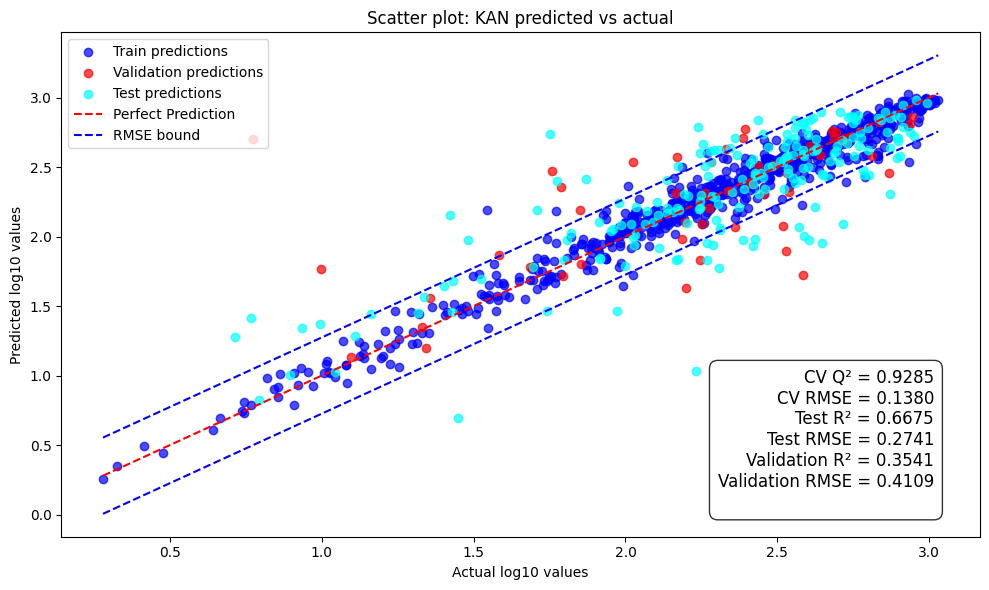

In [ ]:
# Get predictions for training, validation, and test datasets
train_preds = model(train_input).detach().numpy()
val_preds = model(val_input).detach().numpy()
test_preds = model(test_input).detach().numpy()

# Calculate metrics for the test dataset
test_r2 = r2_score(test_label.numpy(), test_preds)
final_test_rmse = np.sqrt(mean_squared_error(test_label.numpy(), test_preds))

# Calculate metrics for the validation set
val_r2 = r2_score(val_label.numpy(), val_preds)
val_rmse = np.sqrt(mean_squared_error(val_label.numpy(), val_preds))

# Visualization of predicted vs actual values
plt.figure(figsize=(10, 6))

# Minimum and maximum values for the plot
min_val = min(min(test_label.numpy()), min(train_label.numpy()), min(val_label.numpy()))
max_val = max(max(test_label.numpy()), max(train_label.numpy()), max(val_label.numpy()))

# Scatter Plot: Train Data (blue points)
plt.scatter(train_label.numpy(), train_preds, alpha=0.7, color='blue', label='Train predictions')

# Scatter Plot: Validation Data (red points)
plt.scatter(val_label.numpy(), val_preds, alpha=0.7, color='red', label='Validation predictions')

# Scatter Plot: Test Data (light blue points)
plt.scatter(test_label.numpy(), test_preds, alpha=0.7, color='cyan', label='Test predictions')

# Ideal prediction line (red dashed line)
ideal_line = np.linspace(min_val, max_val, 100)
plt.plot(ideal_line, ideal_line, 'r--', label='Perfect prediction')

# RMSE lines for the test dataset
plt.plot(ideal_line, ideal_line + final_test_rmse, 'b--', label=f'RMSE bound')
plt.plot(ideal_line, ideal_line - final_test_rmse, 'b--')

# Final metrics for cross-validation and validation
metrics_text = (
    f'CV Q² = {cv_r2:.4f}\n'
    f'CV RMSE = {cv_rmse:.4f}\n'
    f'Test R² = {test_r2:.4f}\n'
    f'Test RMSE = {final_test_rmse:.4f}\n'
    f'Validation R² = {val_r2:.4f}\n'
    f'Validation RMSE = {val_rmse:.4f}\n'
)

plt.text(0.95, 0.05, metrics_text, transform=plt.gca().transAxes,
         fontsize=12, verticalalignment='bottom', horizontalalignment='right',
         bbox=dict(facecolor='white', alpha=0.8, boxstyle='round,pad=0.5', edgecolor='black'))

# Formatting the plot
plt.title('Scatter plot: KAN predicted vs actual')
plt.xlabel('Actual log10 values')
plt.ylabel('Predicted log10 values')
plt.legend(loc='upper left')

# Show the plot
plt.tight_layout()
plt.show()

This part of the code was created to compare the models based on their errors

In [ ]:
# Function to save actual and predicted values along with errors to CSV
def save_predictions_to_csv(model, test_input, test_label, filename="predictions_KAN.csv"):
    with torch.no_grad():
        model.eval()  # Set the model to evaluation mode
        test_predictions = model(test_input)  # Get the predicted values

    # Calculate the absolute error
    errors = np.abs(test_label - test_predictions)

    # Create a DataFrame with actual values, predicted values, and errors
    results_df = pd.DataFrame({
        'Actual Values': test_label.flatten(),
        'Predicted Values': test_predictions.flatten(),
        'Absolute Error': errors.flatten()
    })

    # Save the DataFrame to a CSV file
    results_df.to_csv(filename, index=False)
    print(f"Predictions saved to {filename}")

# Save predictions and errors to CSV
save_predictions_to_csv(model, test_input, test_label)

Predictions saved to predictions_KAN.csv


## SHAP KAN


In [ ]:
!pip install shap

In [ ]:
df.columns

Index(['Area to volume ratio', 'Maximum field range', 'Curie temperature',
       'Experimental temperature', 'Saturation magnetization', 'Coercivity',
       'Remanent magnetization', 'Exchange bias shift',
       'Exchange shift direction', 'Vertical shift',
       'Vertical shift direction', 'Magnetic field strength', 'Sphericity',
       'Geometric anisotropy', 'Core b lattice parameter', 'Core alpha angle',
       'Core beta angle', 'Core gamma angle', 'Shell b lattice parameter',
       'Shell alpha angle', 'Shell beta angle', 'Shell gamma angle',
       'Magnetic ion ratio', 'Temperature difference',
       'Exchange stiffness coefficient', 'Core lattice ratio с to a',
       'Pauling electronegativity of core',
       'Pauling electronegativity of shell',
       'Valence electron concentration of core', 'Work function of core',
       'Valence electron concentration of shell', 'Work function of shell',
       'Pauling electronegativity difference of core',
       'Valence elect

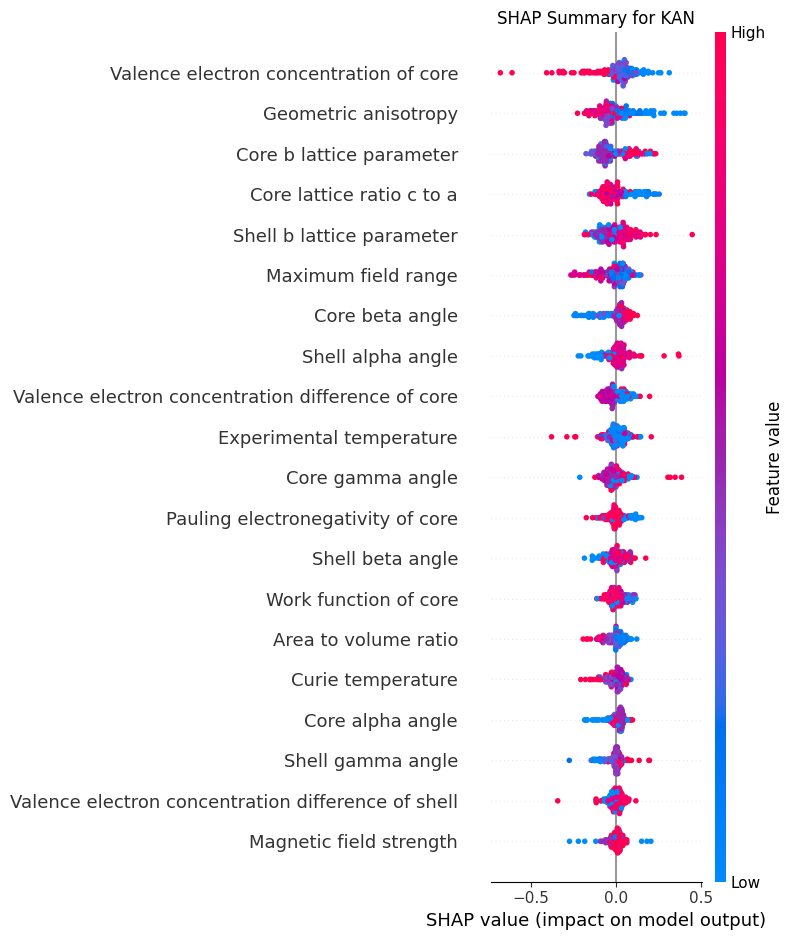

In [ ]:
import shap
import torch
import numpy as np
import matplotlib.pyplot as plt

# Set the model to evaluation mode
model.eval()  # Using the trained model, for example, the variable model

# Convert input data to numpy format
X_train_np = train_input.detach().cpu().numpy()
X_test_np = test_input.detach().cpu().numpy()

# Define the original feature names
feature_names = ['Area to volume ratio', 'Maximum field range', 'Curie temperature',
                'Experimental temperature', 'Saturation magnetization', 'Coercivity',
                'Remanent magnetization', 'Exchange bias shift',
                'Exchange shift direction', 'Vertical shift',
                'Vertical shift direction', 'Magnetic field strength', 'Sphericity',
                'Geometric anisotropy', 'Core b lattice parameter', 'Core alpha angle',
                'Core beta angle', 'Core gamma angle', 'Shell b lattice parameter',
                'Shell alpha angle', 'Shell beta angle', 'Shell gamma angle',
                'Magnetic ion ratio', 'Temperature difference',
                'Exchange stiffness coefficient', 'Core lattice ratio с to a',
                'Pauling electronegativity of core',
                'Pauling electronegativity of shell',
                'Valence electron concentration of core', 'Work function of core',
                'Valence electron concentration of shell', 'Work function of shell',
                'Pauling electronegativity difference of core',
                'Valence electron concentration difference of core',
                'Work function difference of core',
                'Pauling electronegativity difference of shell',
                'Valence electron concentration difference of shell',
                'Work function difference of shell']

# Index of the 'Exchange bias shift' feature to exclude
exclude_feature_idx = feature_names.index('Exchange bias shift')

# Remove 'Exchange bias shift' from both train and test datasets
X_train_np = np.delete(X_train_np, exclude_feature_idx, axis=1)
X_test_np = np.delete(X_test_np, exclude_feature_idx, axis=1)

# Also remove it from the feature names list
feature_names = [name for i, name in enumerate(feature_names) if i != exclude_feature_idx]

# Convert the data back to tensors for SHAP
train_tensor = torch.tensor(X_train_np, dtype=torch.float32)
test_tensor = torch.tensor(X_test_np, dtype=torch.float32)

# Create a SHAP explainer
explainer = shap.GradientExplainer(model, train_tensor)

# Calculate SHAP values for the test data
shap_values = explainer.shap_values(test_tensor)

# Convert SHAP values to numpy array
if isinstance(shap_values, list):
    shap_values_np = np.array(shap_values[0])  # Use the first element for regression
else:
    shap_values_np = np.array(shap_values)

# If SHAP values are multidimensional (samples, features, outputs), average across outputs
if shap_values_np.ndim == 3:
    shap_values_np = shap_values_np.mean(axis=2)

# Create figure and axis before plotting SHAP
plt.figure(figsize=(10, 6))

# Plot SHAP summary plot with updated feature names
shap.summary_plot(shap_values_np, X_test_np, feature_names=feature_names, show=False)

# Add title via matplotlib
plt.title("SHAP Summary for KAN")
plt.tight_layout()  # To prevent plot cutting
plt.show()

# Compare Errors for classic ML and KAN

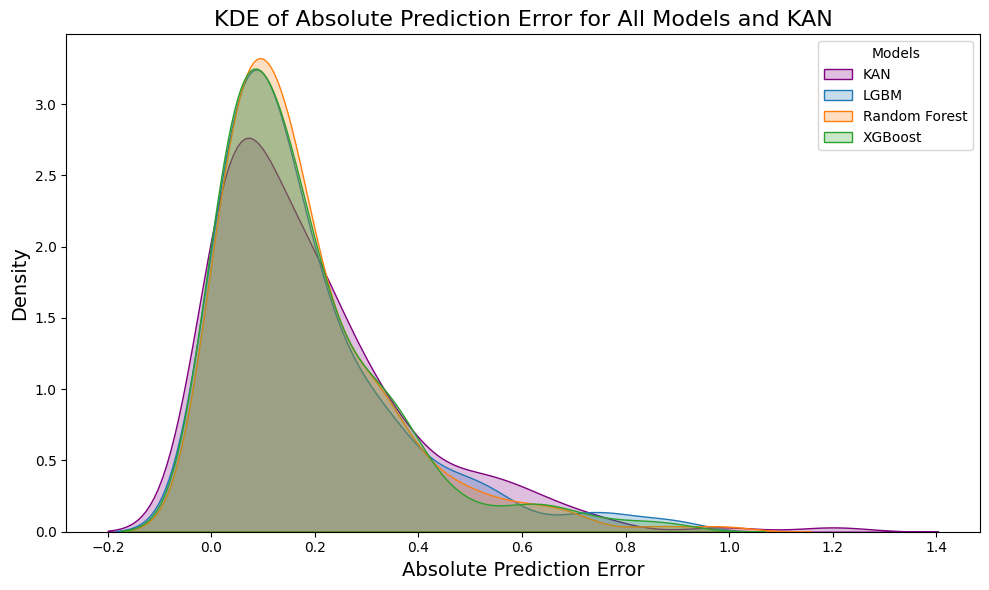

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

kan_data = pd.read_csv('models/KAN/predictions_KAN.csv')
lgbm_data = pd.read_csv('models/KAN/LGBM_log10_predictions.csv')
rf_data = pd.read_csv('models/KAN/RandomForest_log10_predictions.csv')
xgb_data = pd.read_csv('models/KAN/XGB_log10_predictions.csv')

# Extracting columns with absolute errors
kan_error = kan_data['absolute_error']
lgbm_error = lgbm_data['absolute_error']
rf_error = rf_data['absolute_error']
xgb_error = xgb_data['absolute_error']

# Plot creation
plt.figure(figsize=(10, 6))

sns.kdeplot(kan_error, fill=True, color='purple', label='KAN')
sns.kdeplot(lgbm_error, fill=True, label='LGBM')
sns.kdeplot(rf_error, fill=True, label='Random Forest')
sns.kdeplot(xgb_error, fill=True, label='XGBoost')

plt.title('KDE of Absolute Prediction Error for All Models and KAN', fontsize=16)
plt.xlabel('Absolute Prediction Error', fontsize=14)
plt.ylabel('Density', fontsize=14)
plt.legend(title='Models')
plt.tight_layout()
plt.grid(False)

plt.show()

<ipython-input-93-e7d1a966eb26>:43: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x='Quantile_Group', y='MAE', hue='Model', data=all_data, palette="Set2", order=order, ci=None)
/usr/local/lib/python3.10/dist-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.10/dist-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.10/dist-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1

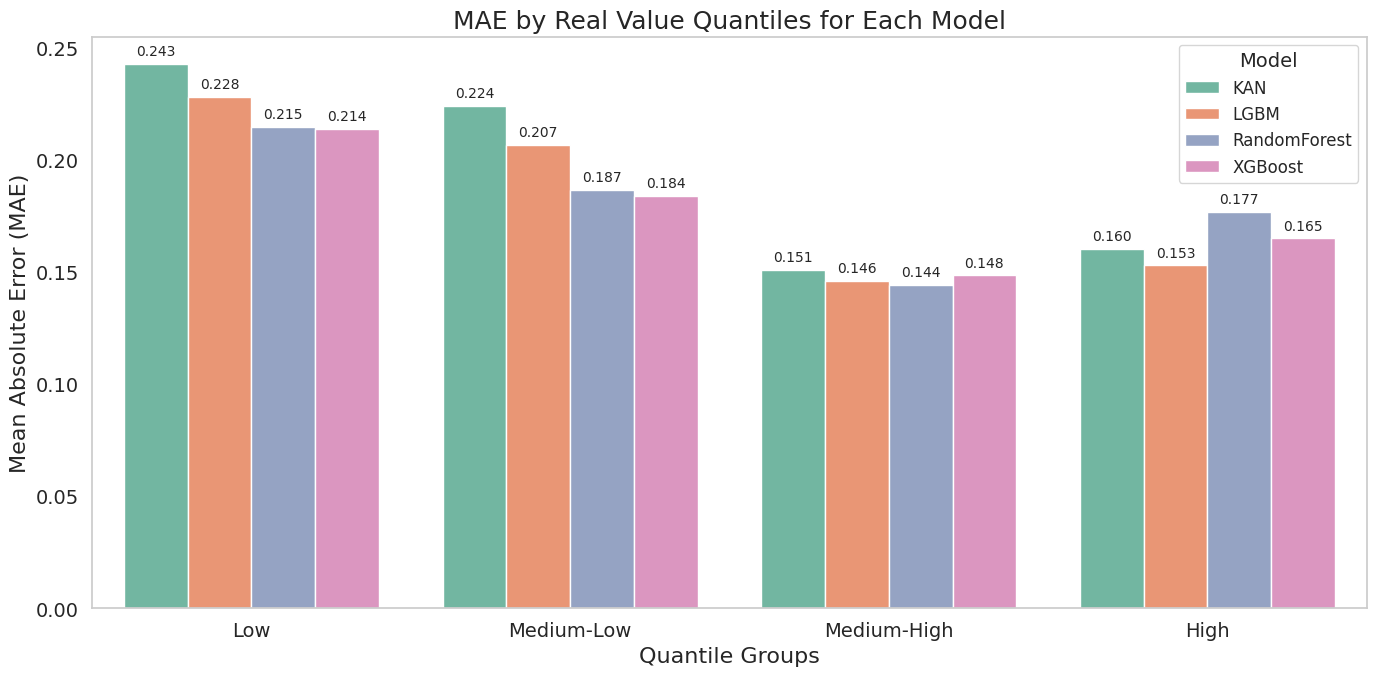

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Load data from CSV files
kan_data = pd.read_csv('/content/predictions_KAN.csv')
lgbm_data = pd.read_csv('/content/LGBM_log10_predictions.csv')
rf_data = pd.read_csv('/content/RandomForest_log10_predictions.csv')
xgb_data = pd.read_csv('/content/XGB_log10_predictions.csv')

# Add quantile groups based on actual values ('log10_real')
kan_data['Quantile_Group'] = pd.qcut(kan_data['log10_real'].rank(method='first'), q=4, labels=['Low', 'Medium-Low', 'Medium-High', 'High'])
lgbm_data['Quantile_Group'] = pd.qcut(lgbm_data['log10_real'].rank(method='first'), q=4, labels=['Low', 'Medium-Low', 'Medium-High', 'High'])
rf_data['Quantile_Group'] = pd.qcut(rf_data['log10_real'].rank(method='first'), q=4, labels=['Low', 'Medium-Low', 'Medium-High', 'High'])
xgb_data['Quantile_Group'] = pd.qcut(xgb_data['log10_real'].rank(method='first'), q=4, labels=['Low', 'Medium-Low', 'Medium-High', 'High'])

# Assign each model a name
kan_data['Model'] = 'KAN'
lgbm_data['Model'] = 'LGBM'
rf_data['Model'] = 'RandomForest'
xgb_data['Model'] = 'XGBoost'

# Combine all data into one DataFrame
all_data = pd.concat([kan_data[['Quantile_Group', 'absolute_error', 'Model']],
                      lgbm_data[['Quantile_Group', 'absolute_error', 'Model']],
                      rf_data[['Quantile_Group', 'absolute_error', 'Model']],
                      xgb_data[['Quantile_Group', 'absolute_error', 'Model']]])

# Rename 'absolute_error' to 'MAE' for clarity
all_data.rename(columns={'absolute_error': 'MAE'}, inplace=True)

# Check for NaN or incorrect data types and remove them
all_data = all_data.dropna(subset=['MAE'])

# Ensure no multidimensional arrays are present in the 'MAE' column
all_data['MAE'] = all_data['MAE'].apply(lambda x: x[0] if isinstance(x, np.ndarray) else x)

# Define the order of quantile groups
order = ['Low', 'Medium-Low', 'Medium-High', 'High']

# Plot the graph
plt.figure(figsize=(14, 7))
sns.barplot(x='Quantile_Group', y='MAE', hue='Model', data=all_data, palette="Set2", order=order, ci=None)

# Add annotations with precise MAE values
for p in plt.gca().patches:
    value = p.get_height()
    if value > 0.01:  # Remove labels for values close to 0
        plt.gca().annotate(format(value, '.3f'),
                           (p.get_x() + p.get_width() / 2., value),
                           ha='center', va='center', xytext=(0, 9),
                           textcoords='offset points', fontsize=10)

# Configure the graph appearance
plt.title('MAE by Real Value Quantiles for Each Model', fontsize=18)
plt.xlabel('Quantile Groups', fontsize=16)
plt.ylabel('Mean Absolute Error (MAE)', fontsize=16)
plt.legend(title='Model', loc='upper right', fontsize=12, title_fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.grid(False, axis='y', linestyle='', alpha=0.7)

# Show the graph
plt.tight_layout()
plt.show()